In [1]:
import os
import pandas as pd
import torch
import numpy as np
from fairseq import utils, tasks
from fairseq import checkpoint_utils
from typing import List, Tuple,Dict
from easyocrlite.reader import ReaderLite
from fairseq.file_io import PathManager
from tasks.mm_tasks.ocr import OcrTask
import cv2
from PIL import Image, ImageDraw,ImageEnhance

2023-08-07 14:43:19.482137: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-07 14:43:20.506256: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
path = './floorplan_best.pt'
model_yolo = torch.hub.load('ultralytics/yolov5', 'custom', path=path)

Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-8-4 Python-3.9.15 torch-2.0.1+cu117 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

Fusing layers... 
Model summary: 267 layers, 46108278 parameters, 0 gradients, 107.6 GFLOPs
Adding AutoShape... 


In [3]:
# turn on cuda if GPU is available
use_cuda = torch.cuda.is_available()
# use fp16 only when GPU is available
use_fp16 = True

mean = [0.5, 0.5, 0.5]
std = [0.5, 0.5, 0.5]

Rect = Tuple[int, int, int, int]
FourPoint = Tuple[Tuple[int, int], Tuple[int, int], Tuple[int, int], Tuple[int, int]]
reader = ReaderLite(gpu=True)
overrides={"eval_cider": False, "beam": 5, "max_len_b": 64, "patch_image_size": 480,
           "orig_patch_image_size": 224, "interpolate_position": True,
           "no_repeat_ngram_size": 0, "seed": 42}
models, cfg, task = checkpoint_utils.load_model_ensemble_and_task(
    utils.split_paths('checkpoints/ocr_general_clean.pt'),
    arg_overrides=overrides
)
# Move models to GPU
for model in models:
    model.eval()
    if use_fp16:
        model.half()
    if use_cuda and not cfg.distributed_training.pipeline_model_parallel:
        model.cuda()
    model.prepare_for_inference_(cfg)
# Initialize generator
generator = task.build_generator(models, cfg.generation)
bos_item = torch.LongTensor([task.src_dict.bos()])
eos_item = torch.LongTensor([task.src_dict.eos()])
pad_idx = task.src_dict.pad()

In [4]:
from PIL import Image, ImageDraw
from torchvision import transforms
from data.mm_data.ocr_dataset import ocr_resize
from utils_.eval_utils import eval_step
def get_images(image_path: str, reader: ReaderLite, **kwargs):
    results = reader.process(image_path, **kwargs)
    return results

def _draw_boxes(image, bounds, color='red', width=2):
    draw = ImageDraw.Draw(image)
    for bound in bounds:
        p0, p1, p2, p3 = bound
        # p0 = (p0[0]-10,p0[1])
        # p3 = (p3[0]-10,p3[1])
        draw.line([*p0, *p1, *p2, *p3, *p0], fill=color, width=width)
    return image

# Construct input for caption task
def construct_sample(task, image: Image, patch_image_size=480):
    patch_image = patch_resize_transform(patch_image_size)(image).unsqueeze(0)
    patch_mask = torch.tensor([True])
    src_text = encode_text(task, "图片上的文字是什么?", append_bos=True, append_eos=True).unsqueeze(0)
    src_length = torch.LongTensor([s.ne(pad_idx).long().sum() for s in src_text])
    sample = {
        "id":np.array(['42']),
        "net_input": {
            "src_tokens": src_text,
            "src_lengths": src_length,
            "patch_images": patch_image,
            "patch_masks": patch_mask,
        },
        "target": None
    }
    return sample
def patch_resize_transform(patch_image_size=480, is_document=False):
    _patch_resize_transform = transforms.Compose(
        [
            lambda image: ocr_resize(
                image, patch_image_size, is_document=is_document
            ),
            transforms.ToTensor(),
            transforms.Normalize(mean=mean, std=std),
        ]
    )
    
    return _patch_resize_transform
def encode_text(task, text, length=None, append_bos=False, append_eos=False):
    bos_item = torch.LongTensor([task.src_dict.bos()])
    eos_item = torch.LongTensor([task.src_dict.eos()])
    pad_idx = task.src_dict.pad()

    s = task.tgt_dict.encode_line(
        line=task.bpe.encode(text),
        add_if_not_exist=False,
        append_eos=False
    ).long()
    
    if length is not None:
        s = s[:length]
    if append_bos:
        s = torch.cat([bos_item, s])
    if append_eos:
        s = torch.cat([s, eos_item])
    return s

# Function to turn FP32 to FP16
def apply_half(t):
    if t.dtype is torch.float32:
        return t.to(dtype=torch.half)
    return t

In [5]:
def ocr(img):
    orig_image = Image.open(img)
    results = get_images(img, reader)
    box_list, image_list = zip(*results)
    _draw_boxes(orig_image, box_list)
    ocr_result_bboxs = []
    for box, image in zip(box_list, image_list):
        image = Image.fromarray(image)
        sample = construct_sample(task, image, cfg.task.patch_image_size)
        sample = utils.move_to_cuda(sample) if use_cuda else sample
        sample = utils.apply_to_sample(apply_half, sample) if use_fp16 else sample

        with torch.no_grad():
            result, scores = eval_step(task, generator, models, sample)
        ocr_result_bboxs.append([box,result[0]['ocr']])

    return orig_image,ocr_result_bboxs

In [6]:
critical_dim_min =200
critical_dim_max =50000
def dim_rec_num(ocr_result_bboxs):
    num_list = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'] #过滤非数字字符
    ocr_rect_num = {}
    for key in range(len(ocr_result_bboxs)):
        rect_list = ocr_result_bboxs[key][0]
        character_list = ocr_result_bboxs[key][1]
        characters = []
        for char in character_list:
            if '.' == char or ' ' == char:
                break
            if (0 != len(characters) and ('o' == char or 'O' == char)):
                characters.append('0')
            if char not in num_list:
                continue
            characters.append(char)
        char_str = "".join(characters)
        if len(char_str) < 1:
            continue
        dim_num = int(char_str)
        if (dim_num > critical_dim_max) or (dim_num <= critical_dim_min):
            continue
        else:
            # 定义一个list，结构为[x1,y1,x2,y2,x3,y3,x4,y4,dim_num]
            point_list=[]
            for item in ocr_result_bboxs[key][0]:
                point_list.extend([item[0],item[1]])
            a = {key: [point_list, dim_num]}
            ocr_rect_num.update(a)
    return ocr_rect_num
def get_up_down_dim(ocr_rect_num):
    # 根据rect位置筛选出最上和最下两组标注信息
    # 求出来一副图总最上和最下的两个标记点（y坐标 ）
    up_err_flag =False
    down_err_flag =False
    #两组尺寸标注结构
    dim_up ={}
    dim_down ={}
    tl_br_list = []
    if len(ocr_rect_num)>0:
        for key in ocr_rect_num:
            rect = ocr_rect_num[key][0]
            tl_br_list.append(rect)
        sorted(tl_br_list, key=(lambda x: x[7]))
        br_y_max = tl_br_list[-2][7]
        br_y_second_max = tl_br_list[-1][7]
        br_y_min = tl_br_list[0][7]
        br_y_second_min = tl_br_list[1][7]
        if br_y_max-br_y_second_max>5:
            br_y_max=br_y_second_max
        if br_y_second_min-br_y_min>5:
            br_y_min=br_y_second_min
        for key in ocr_rect_num:
            if abs(ocr_rect_num[key][0][7] - br_y_min) < 100:
                if (ocr_rect_num[key][1] > critical_dim_max or ocr_rect_num[key][1]<critical_dim_min):
                    continue
                dim_up[key] = [ocr_rect_num[key][0], ocr_rect_num[key][1]]
            elif abs(ocr_rect_num[key][0][7] - br_y_max) < 100:
                if (ocr_rect_num[key][1] > critical_dim_max or ocr_rect_num[key][1]<critical_dim_min):
                    continue
                dim_down[key] = [ocr_rect_num[key][0], ocr_rect_num[key][1]]
            else:
                continue
    return dim_up,dim_down

def get_up_down_sort_list(dim_up,dim_down):
    dim_up_lists = []
    dim_down_lists = []
    for key in dim_up:
        dim_up_list = []
        for num in dim_up[key][0]:
            dim_up_list.append(num)
        dim_up_list.append(dim_up[key][1])
        dim_up_lists.append(dim_up_list)
    for key in dim_down:
        dim_down_list = []
        for num in dim_down[key][0]:
            dim_down_list.append(num)
        dim_down_list.append(dim_down[key][1])
        dim_down_lists.append(dim_down_list)
    dim_up_lists_sorted = sorted(dim_up_lists, key=lambda x: x[8],reverse=True)
    dim_down_lists_sorted = sorted(dim_down_lists, key=lambda x: x[8],reverse=True)
    return dim_up_lists_sorted,dim_down_lists_sorted

def get_up_down_center_point(dim_up_lists_sorted,dim_down_lists_sorted):
    # 计算真实的一个像素代表的尺寸信息,core_up存储每个标注框的中心点的x坐标和对应的真实标注长度：格式为-坐标，长度，坐标，长度。。。。。。
    core_up_x_list =[]
    core_up_y_list =[]
    core_down_x_list =[]
    core_down_y_list =[]
    core_up_list = []
    core_down_list = []
    for idx in range(len(dim_up_lists_sorted)):
        up_tmp_list = []
        dim_up_list = dim_up_lists_sorted[idx]
        if len(dim_up_lists_sorted) < 1:
            break
        else:
            core_up_x = 0.5 * (dim_up_list[0] + dim_up_list[2])
            core_up_y = 0.5 * (dim_up_list[1] + dim_up_list[5])
            core_up_x_list.append(int(core_up_x))
            core_up_y_list.append(int(core_up_y))
            up_tmp_list.append(int(core_up_x))
            up_tmp_list.append(int(core_up_y))
            up_tmp_list.append(dim_up_list[8])
            core_up_list.append(up_tmp_list)

    for idx in range(len(dim_down_lists_sorted)):
        down_tmp_list = []
        dim_down_list = dim_down_lists_sorted[idx]
        if len(dim_down_lists_sorted) < 2:
            break
        else:
            core_down_x = 0.5 * (dim_down_list[0] + dim_down_list[2])
            core_down_y = 0.5 * (dim_down_list[1] + dim_down_list[5])
            core_down_x_list.append(core_down_x)
            core_down_y_list.append(core_down_y)
            down_tmp_list.append(int(core_down_x))
            down_tmp_list.append(int(core_down_y))
            down_tmp_list.append(dim_down_list[8])
            core_down_list.append(down_tmp_list)
    return core_up_list,core_down_list,core_up_x_list,core_up_y_list,core_down_x_list,core_down_y_list

def get_cropped_img(img_path,core_up_list,core_down_list):
    originalImg = cv2.imread(img_path)
    cvtOriginalImg = cv2.cvtColor(originalImg, cv2.COLOR_RGBA2BGR)
    height, width = cvtOriginalImg.shape[:2]
    crop_height = int(height/18)
    if len(core_up_list)>0:
        y_min_up = (core_up_list[0][1]-crop_height) if (core_up_list[0][1]-crop_height)>0 else 0
        up_cropped_img = cvtOriginalImg[y_min_up:core_up_list[0][1]+crop_height, :]
        return up_cropped_img,y_min_up,0
    elif len(core_down_list)>0:
        y_max_down = (core_down_list[0][1]+crop_height) if (core_down_list[0][1]+crop_height)<height else height
        dwon_cropped_img = cvtOriginalImg[core_down_list[0][1]-crop_height:y_max_down, :]
        return dwon_cropped_img,y_max_down,1

In [7]:
import os
def file_name(file_dir):
    L = []
    for root, dirs, files in os.walk(file_dir):
        for file in files:
            L.append(file)
    return L

fileNames = file_name("floorplan_scale/")
print("val len" + str(len(fileNames)),fileNames[49])

val len67 f74dcd69-684c-4844-b439-2e8190a0fc0b_resized.png


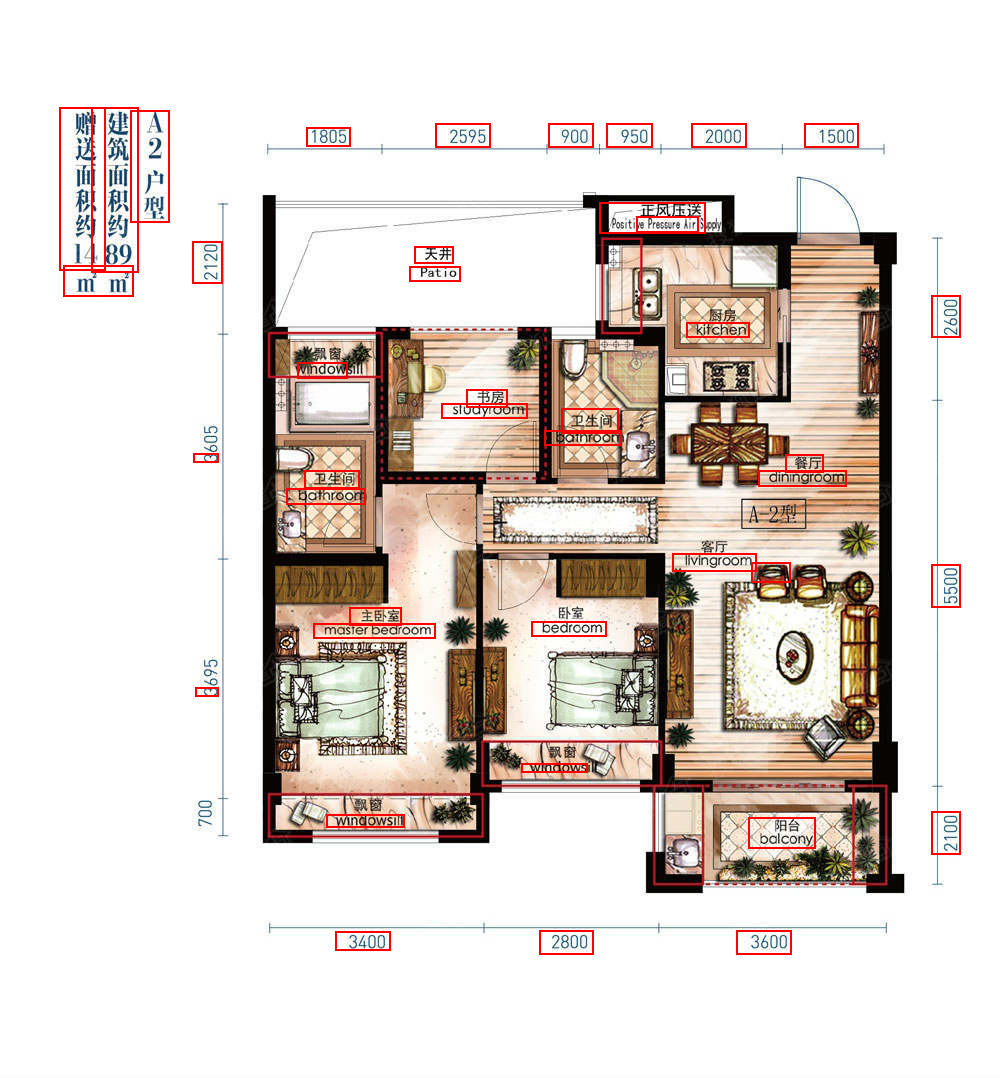

In [48]:
img_path ="floorplan_scale/"+"0c23384a-b5dc-4bdb-a654-9aaf64acbc1d.png"
orig_image,ocr_result_bboxs = ocr(img_path)
orig_image

41
boundary: 0  y_value: 76 ocr_point_list: [[462, 135, 2595], [718, 135, 2000], [328, 136, 1805], [831, 135, 1500], [629, 135, 950], [570, 135, 900]]


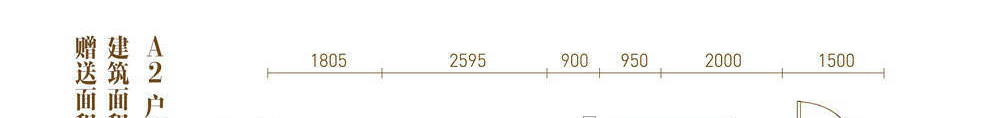

In [49]:
print(len(ocr_result_bboxs))
ocr_rect_num = dim_rec_num(ocr_result_bboxs)
dim_up,dim_down = get_up_down_dim(ocr_rect_num)
dim_up_lists_sorted,dim_down_lists_sorted = get_up_down_sort_list(dim_up,dim_down)
core_up_list,core_down_list,core_up_x_list,core_up_y_list,core_down_x_list,core_down_y_list = get_up_down_center_point(dim_up_lists_sorted,dim_down_lists_sorted)
cropped_img,y_value,boundary_idx = get_cropped_img(img_path,core_up_list,core_down_list)
# cv2.imwrite("check_result/[boundary]"+img.split('.')[0]+"_boundary_"+str(boundary_idx)+".jpg", cropped_img)
ocr_point_list = []
if boundary_idx==0:
    ocr_point_list = core_up_list
elif boundary_idx==2:
    ocr_point_list = core_down_list
print("boundary:",boundary_idx," y_value:",y_value, "ocr_point_list:",ocr_point_list)
image_show = Image.fromarray(cv2.cvtColor(cropped_img,cv2.COLOR_BGR2RGB))
image_show

In [50]:
import copy
image = copy.deepcopy(image_show)
results = model_yolo(image).pandas().xyxy[0]
bboxs = []
for idx, item in results.iterrows():
    x1 = item['xmin']
    y1 = item['ymin']
    x2 = item['xmax']
    y2 = item['ymax']
    bboxs.append([x1,y1,x2,y2,item['confidence']])
print(bboxs)

[[535.7085571289062, 62.963233947753906, 556.8427734375, 85.37470245361328, 0.6559088230133057], [772.8553466796875, 63.50072479248047, 791.6393432617188, 82.8573226928711, 0.6541271805763245], [651.9896240234375, 64.43022155761719, 670.21337890625, 84.39803314208984, 0.6539731025695801], [372.7575988769531, 63.32936096191406, 392.1471862792969, 83.80553436279297, 0.6534491181373596], [872.571533203125, 62.964393615722656, 893.7415771484375, 84.6810073852539, 0.6517459154129028], [257.45263671875, 62.516902923583984, 280.2791748046875, 85.50518798828125, 0.6467175483703613], [592.0781860351562, 64.89137268066406, 606.7389526367188, 82.87008666992188, 0.5961440801620483]]


[855.8477172851562, 105.83413696289062, 908.1130981445312, 148.5785675048828, 0.7548646330833435]
[2061.092529296875, 166.66082763671875, 2114.850341796875, 209.55616760253906, 0.7280570268630981]
[1482.245361328125, 167.38946533203125, 1532.7677001953125, 207.99578857421875, 0.7252519130706787]
[1081.0679931640625, 166.11671447753906, 1135.8011474609375, 210.9014892578125, 0.7247170805931091]
[1924.353759765625, 166.6138153076172, 1975.32275390625, 207.94578552246094, 0.7083174586296082]
[2061.77490234375, 106.11383819580078, 2115.855712890625, 146.5104522705078, 0.6930322647094727]
[897.5807495117188, 163.6100311279297, 938.4929809570312, 213.1475830078125, 0.635567843914032]


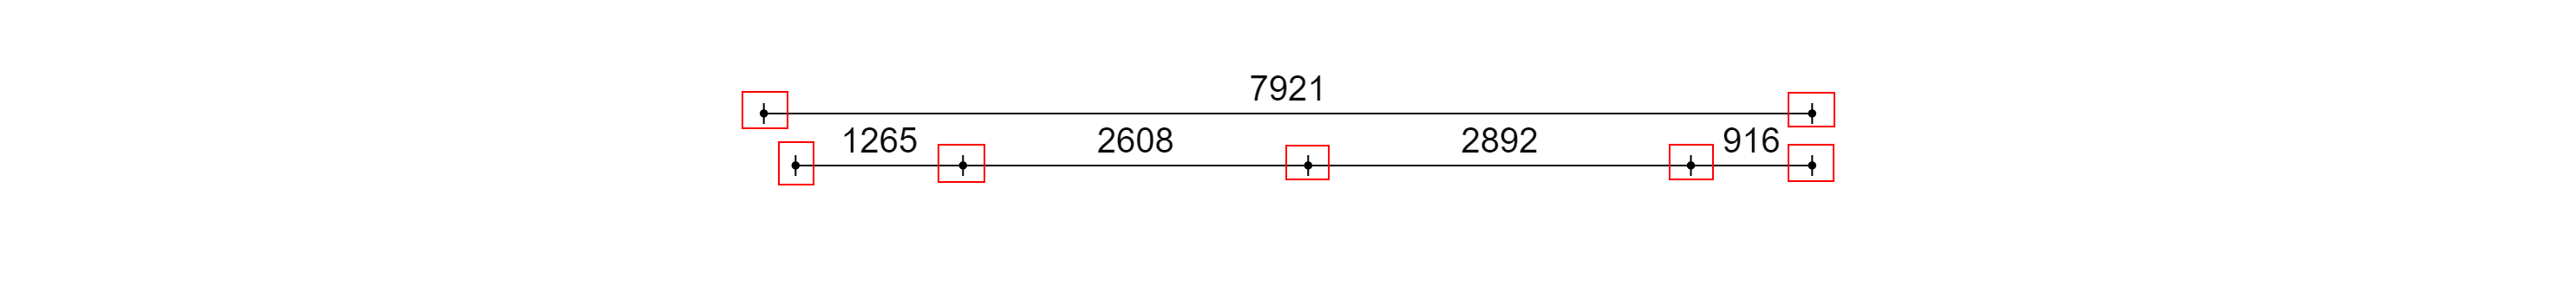

In [35]:
def draw_boxes(image, bounds, color='red', width=2):
    copy_image = copy.deepcopy(image)
    draw = ImageDraw.Draw(copy_image)
    for bound in bounds:
        print(bound)
        x1, y1, x2, y2,conf = bound
        draw.rectangle([x1, y1, x2, y2], outline=color,fill=None,width=width)
    return copy_image
bboxs_image = draw_boxes(image,bboxs)
bboxs_image

(879, 130) 160 190 130
(879, 130) 160 190 130
(2089, 190) 160 190 130
(2089, 190) 160 190 130
(1508, 190) 160 190 130
(1508, 190) 160 190 130
(1110, 190) 160 190 130
(1110, 190) 160 190 130
(1949, 190) 160 190 130
(1949, 190) 160 190 130
(2088, 130) 160 190 130
(2088, 130) 160 190 130
(916, 190) 160 190 130
(916, 190) 160 190 130


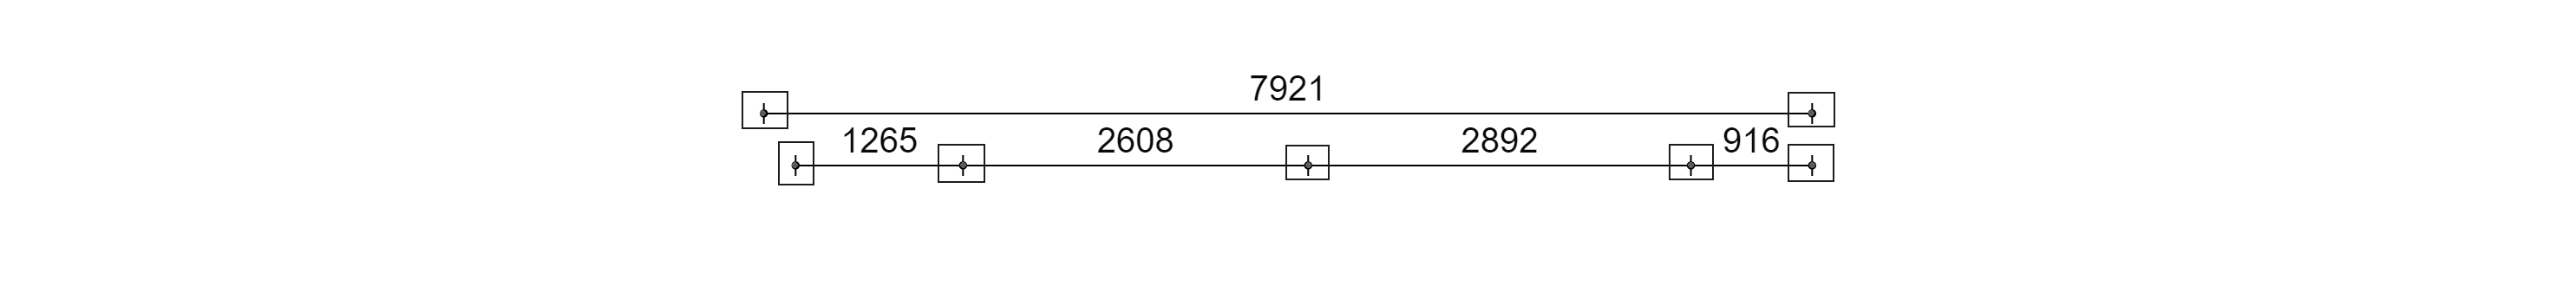

In [36]:
import numpy as np
corner_point_map = {}
originalImg = cv2.cvtColor(np.asarray(image),cv2.COLOR_RGBA2BGR) 
tmp_corner_y = []
tmp_corner_x = []
corner_point_list = []
for bound in bboxs:
    x1, y1, x2, y2,conf = bound
    crop_img = image.crop((x1, y1, x2, y2))
    crop_img_array = cv2.cvtColor(np.asarray(crop_img),cv2.COLOR_BGR2GRAY) 
    corners = cv2.goodFeaturesToTrack(crop_img_array, 10,qualityLevel =  0.6, minDistance = 3,useHarrisDetector=False)
    if corners is not None and len(corners)>0:
        for pt in corners:
            x = np.int32(pt[0][0])+x1
            y = np.int32(pt[0][1])+y1
            tmp_corner_y.append(int(y))
            corner_point_list.append([int(x),int(y)])
center_y = int((max(tmp_corner_y)+min(tmp_corner_y))/2)
max_y = max(tmp_corner_y)
min_y = min(tmp_corner_y)
tmp_up = []
tmp_dwon = []
for y in tmp_corner_y:
    if y>center_y:
        tmp_up.append(y)
    else:
        tmp_dwon.append(y)
up_center_y = center_y
down_center_y = center_y
if len(tmp_up)>0:
    up_center_y = int((max(tmp_up)+min(tmp_up))/2)
if len(tmp_dwon)>0:
    down_center_y = int((max(tmp_dwon)+min(tmp_dwon))/2)

bboxs_image_cv2 = cv2.cvtColor(np.asarray(bboxs_image),cv2.COLOR_BGR2GRAY) 
for item in corner_point_list:
    b = 92
    g = 92
    r = 205
    tmp_corner_x.append(int(item[0]))
    if np.abs(max_y-min_y)>10:
        tmp = item[1]
        if item[1]>center_y:
            tmp =up_center_y
        else:
            tmp =down_center_y
        corner_point_map[item[0]] = tmp
        print((item[0], tmp),center_y,up_center_y,down_center_y)
        cv2.circle(bboxs_image_cv2, (item[0], tmp),radius=2,color=(b, g, r),thickness=2)
    else:
        corner_point_map[item[0]] = center_y
        print((item[0], center_y),tmp_corner_y,center_y)
        cv2.circle(bboxs_image_cv2, (item[0], center_y),radius=2,color=(b, g, r),thickness=2)
image_show = Image.fromarray(cv2.cvtColor(bboxs_image_cv2,cv2.COLOR_BGR2RGB))
image_show

In [37]:
def closest(mylist, number):
    answer = []
    for i in mylist:
        answer.append(abs(number-i))
    index = answer.index(min(answer))
    if index>0 and mylist[index]>number>mylist[index-1]:
        index = index -1
    return index

In [38]:
print("boundary_idx:",boundary_idx," ocr_points:",ocr_point_list," corner_points:",corner_point_map)
ocr_corner_list = []
for ocr_point in ocr_point_list:
    ocr_x = ocr_point[0]
    ocr_y = ocr_point[1]
    ocr_value = ocr_point[2]
    corner_x_list = sorted(list(corner_point_map.keys()))
    for corner_x in corner_x_list:
        corner_y = corner_point_map[corner_x]+y_value
        if np.abs(corner_y-ocr_y)<20:
            closest_left_index = closest(corner_x_list,ocr_x)
            if closest_left_index+1 <len(corner_x_list) and corner_x_list[closest_left_index]<=corner_x<=corner_x_list[closest_left_index+1]:
                ocr_corner_list.append([ocr_x,corner_x_list[closest_left_index],corner_x_list[closest_left_index+1],corner_y,ocr_value])
                break
print("ocr_corner_list:",ocr_corner_list)
up_ratios=[]
for item in ocr_corner_list:
    ocr_x = item[0]
    corner_start_x = item[1]
    corner_end_x = item[2]
    corner_y = item[3]
    ocr_value = item[4]
    ratio = (corner_end_x-corner_start_x)/ocr_value
    up_ratios.append(ratio)
print("up_ratios:",up_ratios)


boundary_idx: 0  ocr_points: [[1728, 234, 2892], [1310, 234, 2608], [1013, 234, 1265], [2019, 234, 916], [1477, 172, 792]]  corner_points: {879: 130, 2089: 190, 1508: 190, 1110: 190, 1949: 190, 2088: 130, 916: 190}
ocr_corner_list: []
up_ratios: []
